In [55]:
import os
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from importlib import reload
path = os.path.abspath(os.path.dirname(os.getcwd()))
path = os.path.join(path, 'scripts')
sys.path.append(path)

import projectknn as KNN
import projectAvgHikingTime as AHT
import projectDataModRetrieve as DMR

KNN = reload(KNN)
AHT = reload(AHT)
DMR = reload(DMR)

In [46]:
path = os.path.abspath(os.path.dirname(os.getcwd()))
path1 = os.path.join(path, "data/exercise.csv")
path2 = os.path.join(path, "data/calories.csv")
exercisedf = pd.read_csv(path1)
caloriesdf = pd.read_csv(path2)

df = pd.merge(exercisedf, caloriesdf, on = 'User_ID')
dataset = df.drop(columns = ['User_ID', 'Heart_Rate', 'Body_Temp']).dropna()
# Dropping User_ID because it has no use, heartrate and body temp are not obtainable data in the scope of this project
#dataset
#dataset = pd.get_dummies(dataset, prefix = 'Sex', dtype = 'float')
dataset.drop(columns = 'Sex').corr()['Calories'] #using age, duration, and Sex

Age         0.154395
Height      0.017537
Weight      0.035481
Duration    0.955421
Calories    1.000000
Name: Calories, dtype: float64

female: 9.729054742814245
male: 17.20091789716846


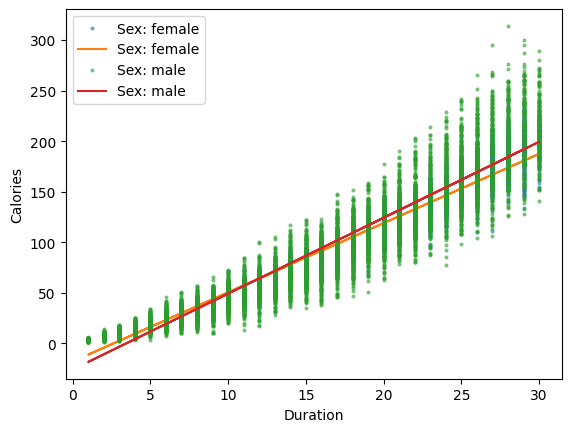

In [30]:
groups = pd.DataFrame(dataset, columns = ['Duration', 'Calories', 'Sex'])
groups = groups.groupby('Sex')

fig, ax = plt.subplots()
for Sex, item in groups:
    ax.set_xlabel(item.columns.values[0])
    ax.set_ylabel(item.columns.values[1])
    ax.plot(item.iloc[:,0], item.iloc[:,1], marker='o', linestyle='', markersize=2, alpha = 0.5, label = 'Sex: ' + str(Sex))
    regression = stats.linregress(item.iloc[:,0],item.iloc[:,1])
    ax.plot(item.iloc[:,0], regression.intercept + regression.slope*item.iloc[:,0], markersize=1, alpha = 1, label = 'Sex: ' + str(Sex))
    ax.legend()
    for x,y in zip(item.iloc[:,0], item.iloc[:,1]):
        MAE = MAE + abs(y - (regression.intercept + regression.slope*x))
    MAE = MAE / len(item.iloc[:,0].values)
    print(str(Sex) + ": " + str(MAE))

[7.651576945957734, 14.746683667185271]
[7.922638932048061, 14.841419712835169]


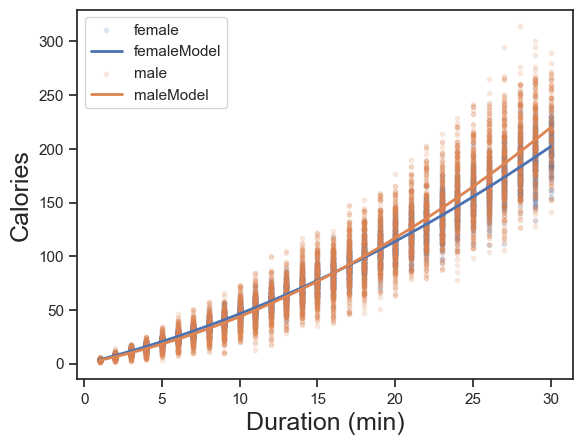

In [47]:
regularMAE = []
SexMAE = []

fig, ax = plt.subplots()

x = dataset['Duration'].to_numpy()
y = dataset['Calories'].to_numpy()

quad_reg2 = LinearRegression()

x = x.reshape(-1,1)

quad2 = PolynomialFeatures(degree=2)
X = quad2.fit_transform(x)

quad_reg2.fit(X,y.reshape(-1,1))


for Sex, item in groups:
    x = item.iloc[:,0].to_numpy()
    y = item.iloc[:,1].to_numpy()
    # Create a linear regression object
    quad_reg = LinearRegression()

    # Reshaping feature
    x = x.reshape(-1,1)

    # Transfomr features to a polynomial regression
    quad = PolynomialFeatures(degree=2)
    X = quad.fit_transform(x)

    # Training
    quad_reg.fit(X,y.reshape(-1,1))

    # Selecting a interval for duration an adapting shape
    T_val = np.linspace(x.min(),x.max(),100).reshape(-1,1)
    T_val_quad = quad.fit_transform(T_val)

    # Predicting values
    C_quad_model = quad_reg.predict(T_val_quad)

    ax.scatter(x,y,label = str(Sex),alpha = 0.15,marker='.',zorder=1)
    ax.plot(T_val,C_quad_model, label = str(Sex)+'Model', lw = 2,zorder=2)
    ax.set_xlabel('Duration (min)', size = 18)
    ax.set_ylabel('Calories', size = 18); 
    ax.legend()
    SexMAE.append(metrics.mean_absolute_error(quad_reg.predict(X),y))
    regularMAE.append(metrics.mean_absolute_error(quad_reg2.predict(X),y))

print(SexMAE)
print(regularMAE)       

#From this we deduce that Sex should be a factor when building the final model, considering that the duration of the hikes will be a lot longer than this.

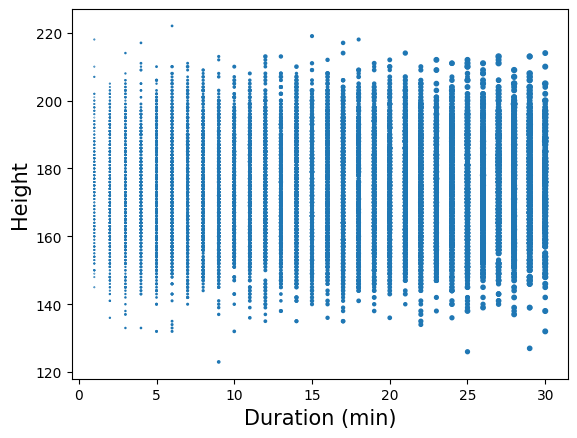

In [18]:
plt.xlabel('Duration (min)', size = 15)
plt.ylabel('Height', size = 15); 
plt.scatter(dataset['Duration'], dataset['Height'], s = dataset['Calories']/20)
#it seems for the same duration, the calories burnt by age doesn't change significantly, so shouldn't be included in the final model.
#height and weight do not contribute, assumed by their correlation to calories.

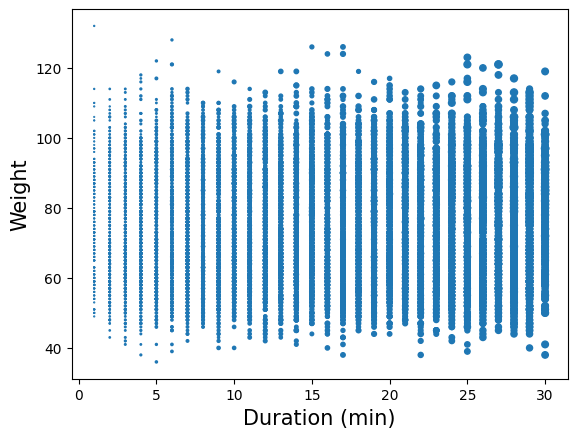

In [19]:
plt.xlabel('Duration (min)', size = 15)
plt.ylabel('Weight', size = 15); 
plt.scatter(dataset['Duration'], dataset['Weight'], s = dataset['Calories']/10)

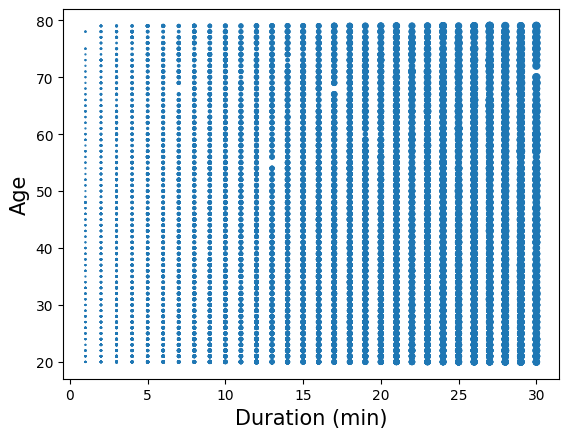

In [20]:
plt.xlabel('Duration (min)', size = 15)
plt.ylabel('Age', size = 15); 
plt.scatter(dataset['Duration'], dataset['Age'], s = dataset['Calories']/10)

In [40]:
#The final model will have Sex and duration as features 
dataset = pd.get_dummies(dataset, prefix = 'Sex', dtype = 'float')

modelData = dataset.drop(dataset.columns.difference(['Duration', 'Sex_female', 'Sex_male', 'Calories']),axis = 1)
linregMAE = 0
polyregMAE = 0



for index in range(0,30):
    
    X_train, X_test, y_train, y_test = train_test_split(modelData.drop('Calories', axis = 1), modelData['Calories'], test_size = 0.3)

    #linreg model
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    linregMAE = linregMAE + metrics.mean_absolute_error(reg.predict(X_test), y_test)
    

    X_train, X_test, y_train, y_test = train_test_split(modelData.drop('Calories', axis = 1), modelData['Calories'], test_size = 0.3)
    #polyreg model
    poly = PolynomialFeatures(degree = 2)
    polyXtrain = poly.fit_transform(X_train)
    poly.fit(polyXtrain, y_train)
    polyReg = LinearRegression()
    polyReg.fit(polyXtrain, y_train)

    polyXtest = poly.fit_transform(X_test)

    polyregMAE = polyregMAE + metrics.mean_absolute_error(polyReg.predict(polyXtest), y_test)

linregMAE = linregMAE/30
polyregMAE = polyregMAE/30
print('linear regression mean absolute error: ' + str(linregMAE))
print('polynomial regression mean absolute error: ' + str(polyregMAE))

#since the polynomial(quadratic) returns a smaller MAE in testing by around 2.4 calories, we move forward with it.

linear regression mean absolute error: 13.531885839452567
polynomial regression mean absolute error: 11.335127437156846


In [47]:
#next: knn on the hiking trails difficulty through length, ascent, descent https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor
path = os.path.abspath(os.path.dirname(os.getcwd()))
path = os.path.join(path, "data/gpx-tracks-from-hikr.org.csv")
dataframe = pd.read_csv(path)


In [48]:
#processing the data for knn
df = dataframe.drop(columns = dataframe.columns.difference(['length_2d', 'uphill', 'downhill', 'difficulty', 'max_elevation', 'min_elevation']))
df['difficulty'] = df.difficulty.replace(to_replace='T', regex=True, value='').replace(to_replace='[^\d]', regex=True, value='').astype('float')
df = df[(df != 0.0).all(axis=1)]
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
for item in df.columns.difference(['difficulty']):
    df[item]= df[item]/1000
df['length_2d'] = df['length_2d']**0.44 #normalizing the length so its std is consistent with the rest of the features for KNN
df.reset_index(drop = True, inplace = True)
df


,max_elevation,uphill,difficulty,min_elevation,downhill,length_2d
0,1.934470,0.612880,2.0,1.322960,0.609670,2.852914
1,2.186210,0.614753,3.0,1.266400,1.193733,3.012493
2,2.265000,2.255976,3.0,0.176540,2.177626,3.971874
3,0.962420,0.882312,2.0,0.388510,0.901052,4.114856
4,0.697570,0.310662,2.0,0.438500,0.305372,3.701775
...,...,...,...,...,...,...
10215,1.603136,0.672731,3.0,0.936461,0.007498,1.816305
10216,1.664660,0.928770,2.0,0.826870,0.925880,3.106278
10217,1.658300,0.821240,1.0,0.882600,0.839040,2.612039
10218,0.646620,0.307855,1.0,0.425040,0.289595,3.482831


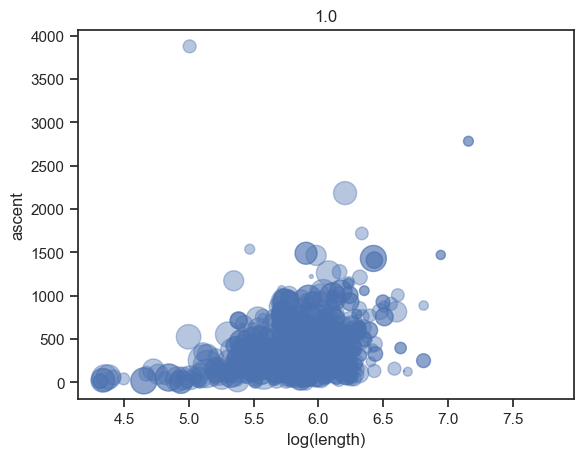

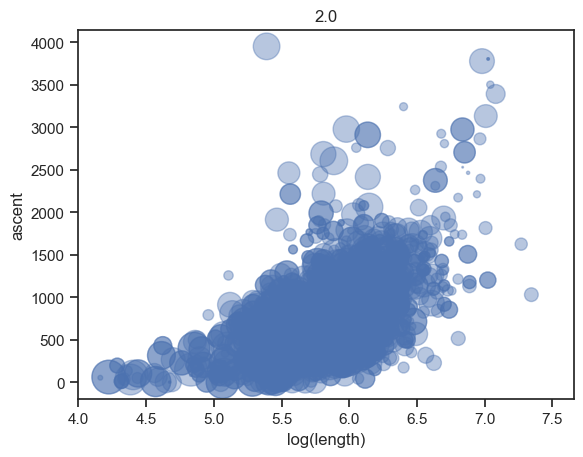

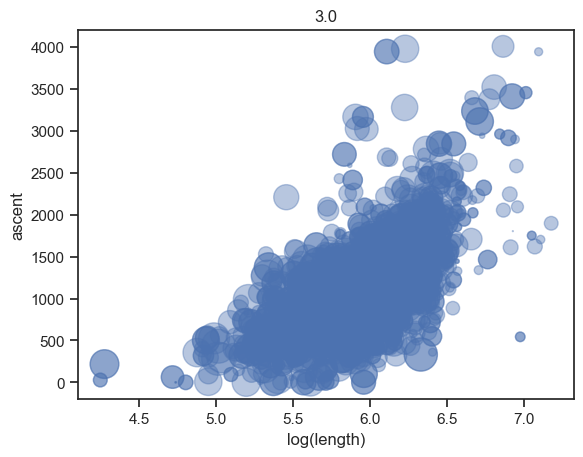

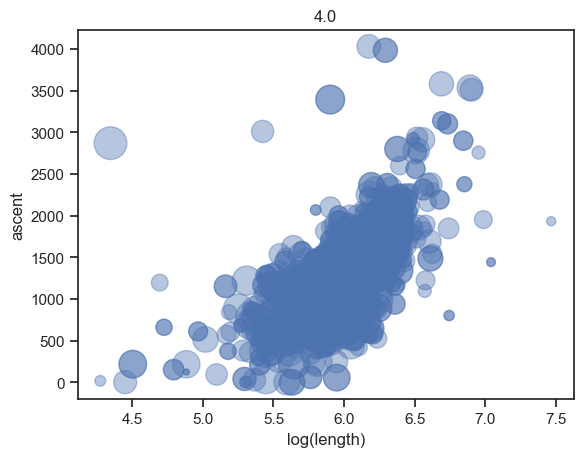

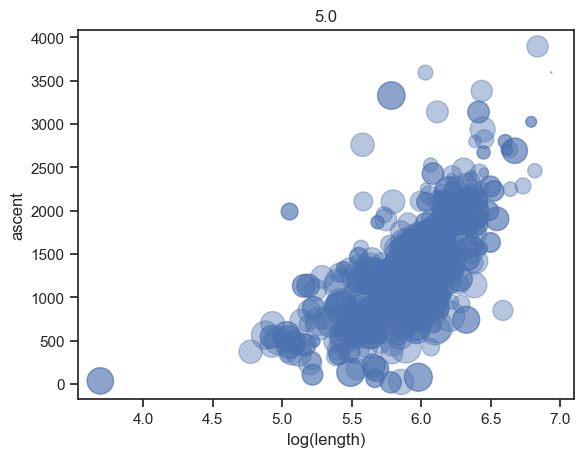

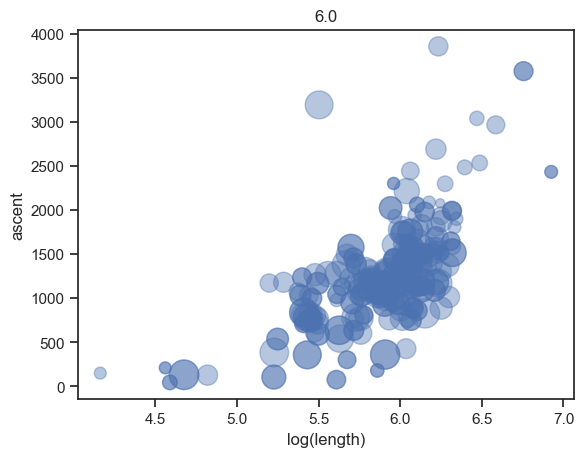

In [119]:
plotdf = df.groupby('difficulty')
# fig, ax = plt.subplots()
for difficulty, item in plotdf:
    fig, ax = plt.subplots()
    item['length_2d'] = np.log(item['length_2d'])
    ax.set_title(label = str(difficulty))
    ax.set_xlabel('log(length)')
    ax.set_ylabel('ascent')
    ax.scatter(item['length_2d'], item['uphill'], s = item['min_elevation']*0.2, alpha = 0.4)
    
#decide it is worthwhile to try a knn network to find difficulty 

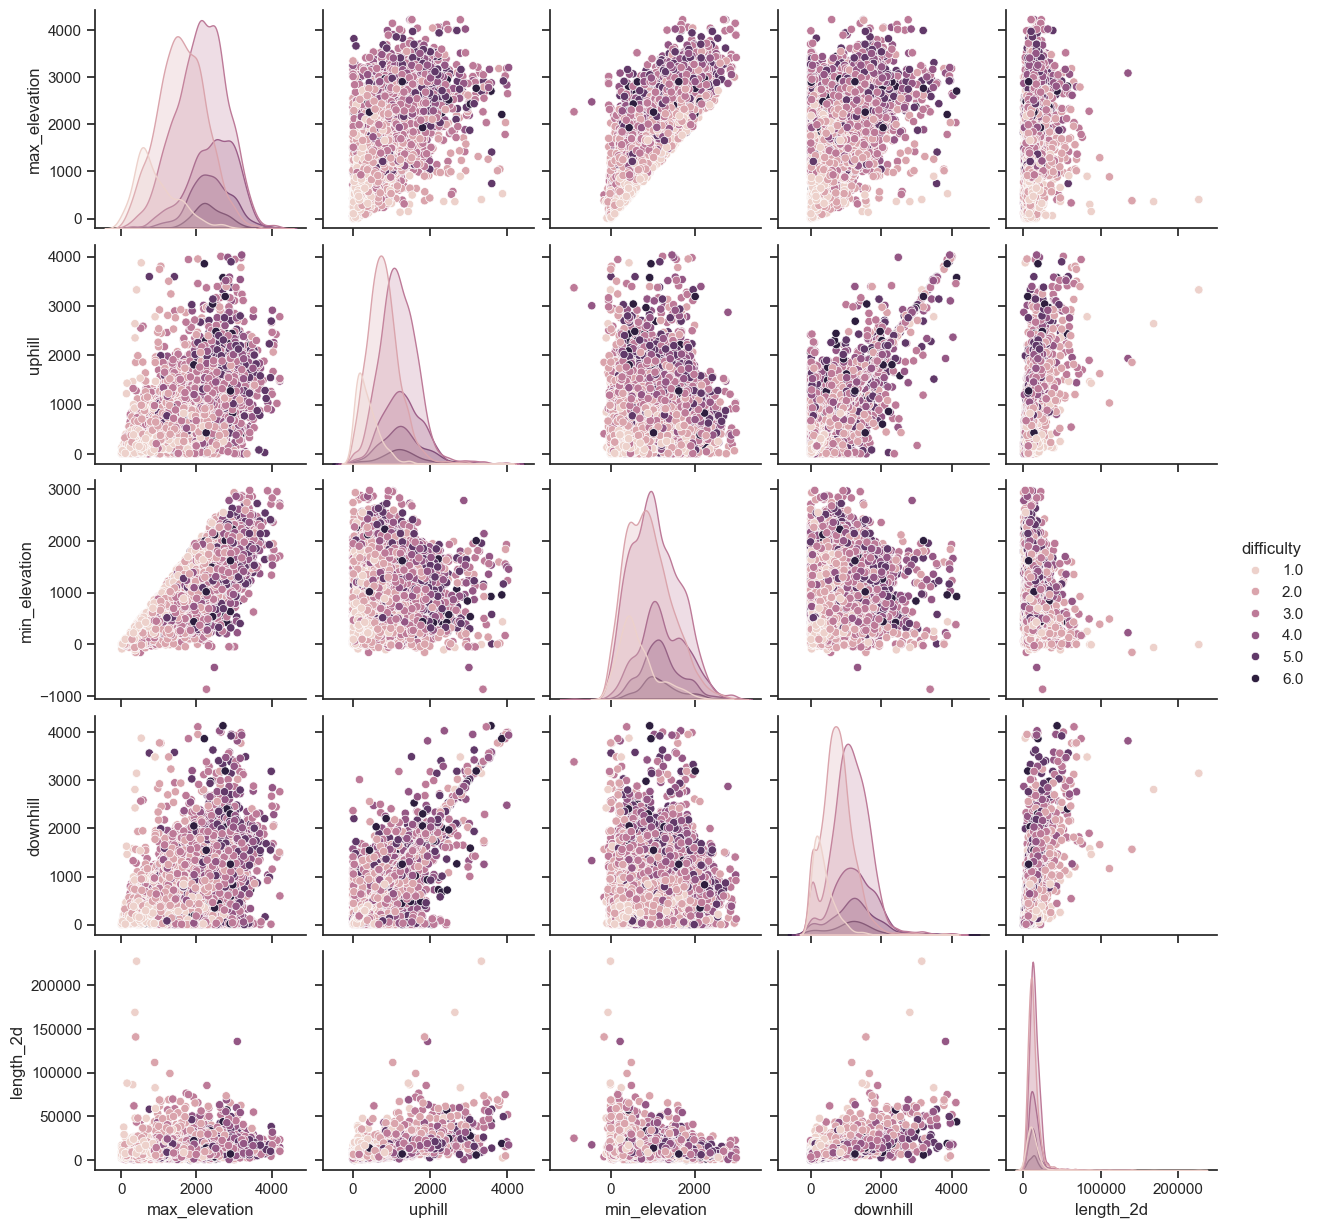

In [22]:
sns.set_theme(style="ticks")

sns.pairplot(df, hue= 'difficulty')
#from the scatter matrix we can see how the color hue is different in each area of the graph. therefore, it is worthwhile to attempt to capture its patterns.

In [56]:
#knn model
df2 = df.copy()
display(df2.iloc[0])

FinalMAE = 0
for index in range(0,10):
    MAE = 0
    X_train, X_test, y_train, y_test = train_test_split(df2.drop('difficulty', axis = 1), df2['difficulty'], test_size = 0.2)
    for x,y in zip(X_test.values, y_test.values):
        MAE = MAE + abs(KNN.predict(df2, x)-y)
    MAE = MAE/len(y_test.values)
    print(index)
    FinalMAE = FinalMAE + MAE
FinalMAE = FinalMAE / 10
print(FinalMAE)
#with a estimated MAE of around 0.526, the model works sufficiently. 

max_elevation    1.934470
uphill           0.612880
difficulty       2.000000
min_elevation    1.322960
downhill         0.609670
length_2d        2.852914
Name: 0, dtype: float64

0
1
2
3
4
5
6
7
8
9
0.526174168297456


In [ ]:
#polynomial regression model polyReg
X_train, X_test, y_train, y_test = train_test_split(modelData.drop('Calories', axis = 1), modelData['Calories'], test_size = 0.3)
X_train = modelData.drop('Calories', axis = 1)
y_train = modelData['Calories']
poly = PolynomialFeatures(degree = 2)
polyXtrain = poly.fit_transform(X_train)
poly.fit(polyXtrain, y_train)
polyReg = LinearRegression()
polyReg.fit(polyXtrain, y_train)

polyXtest = poly.fit_transform(X_test)
polyregMAE = metrics.mean_absolute_error(polyReg.predict(polyXtest), y_test)
print(polyregMAE)

In [132]:
gpxXML = DMR.returnGPXData(0) #to add a gpx file of your own, put the gpx file in the folder named inputData, and enter the name of the file into the function.
#if number between 0 and 12000 inputted, instead the code pulls an gpx xml from the gpx database
time, difFeatures = AHT.calcAvgHikingTime(gpxXML)
difFeatures[4] = difFeatures[4]**0.48
polyFeatures = poly.fit_transform(pd.DataFrame.from_dict({'Duration':[time*60], 'Sex_female':[1], 'Sex_male':[0]})) #input your sex here: 1 for yes, 0 for no for each sex
print('Predicted time in hours: ' + str(round(time,2)))
print('Predicted calories: ' + str(round(polyReg.predict(polyFeatures)[0],2)))
print('Predicted trail difficulty: ' + str(knn.predict(df2, difFeatures)))
